<a href="https://colab.research.google.com/github/dj1095/movie-recommendation-system/blob/master/Netflix_Recommendation_System_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import numpy as np
import pandas as pd

import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from google.colab import drive
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [98]:
def create_sparse_tensor(index_arr,value_arr,dimension):
  return tf.SparseTensor(indices=index_arr, values=value_arr, dense_shape=dimension)
  

In [99]:
def build_cost_function(train_loss,users_vector,movies_vector,r_coefficient=0.1):
  return train_loss + ( r_coefficient * (tf.math.reduce_sum(tf.math.abs(users_vector))/users_vector.shape[0].value + 
                                                       tf.math.reduce_sum(tf.math.abs(movies_vector))/movies_vector.shape[0].value))

In [100]:
def calculate_mean_square_err(sp_matrix, users_vector,movies_vector):
  dot_product = tf.matmul(users_vector, movies_vector, transpose_b=True)
  #needs gpu  
  predictions = tf.gather_nd(dot_product,sp_matrix.indices)
  return tf.losses.mean_squared_error(sp_matrix.values, predictions)

In [101]:
#train
def train_model(users_vector,movies_vector,feedback_loss_val,iteration_count=100):
  loss_list = []
  embedding_vars = {"user_id": users_vector, "movie_id": movies_vector}
  embeddings = {k: None for k in embedding_vars}
  #print(embeddings)
  optimizer = tf.train.GradientDescentOptimizer
  train_op = optimizer(learning_rate).minimize(feedback_loss_val)
  local_init_op = tf.group(tf.variables_initializer(optimizer(learning_rate).variables()), tf.local_variables_initializer())
  with tf.Session().as_default() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    local_init_op.run()
    iterations = []
    metrics = [{'loss': feedback_loss_val}]
    metrics_vals = {}
    # Training the model
    for i in range(iteration_count + 1):
      _, results = session.run((train_op, metrics))
      loss_list.append(results[0]['loss'])
      if i == iteration_count:
        for metric_val, result in zip(metrics_vals, results):
          # Embed the responses
          for k, v in result.items():
            metric_val[k].append(v)
    for user, variable in embedding_vars.items():
      embeddings[user] = variable.eval()

  plt.plot(np.arange(0,iteration_count+1),loss_list)
  plt.title('Stochaistic Gradient Descent')
  plt.show()
  return embeddings

In [102]:
def get_movie_recommendation(embeddings,movies,user_id):
  user_embedding = embeddings['user_id'][user_id]
  movie_embedding = embeddings['movie_id']
  scores = user_embedding.dot(movie_embedding.T)
  rec_df = pd.DataFrame({ 'movie_id': movies['movie_id'],'title': movies['title'],'score': list(scores),})
  return rec_df.sort_values('score', ascending=False)

In [103]:
drive.mount('/content/drive/')
PATH = '/content/drive/My Drive/Colab Notebooks/Netflix_Movie_Recomendation/ml-100k'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


 Read Data from csv files

In [104]:
users_df = pd.read_csv(PATH+'/u.user', sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'])
ratings_by_user = pd.read_csv(PATH+'/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'], encoding='latin-1')
users_df.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [105]:
users_df.occupation.unique()

array(['technician', 'other', 'writer', 'executive', 'administrator',
       'student', 'lawyer', 'educator', 'scientist', 'entertainment',
       'programmer', 'librarian', 'homemaker', 'artist', 'engineer',
       'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor'],
      dtype=object)

In [106]:

movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movie_genre = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy","Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror","Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movie_columns.extend(movie_genre)
    
movies_df = pd.read_csv(PATH+'/u.item', sep='|', names=movie_columns, encoding='latin-1')
movies_df.head()


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Data Pre-Processing

In [107]:
movies_df = movies_df.drop(columns=['release_date', 'video_release_date', 'imdb_url'])
movies_df.head()

,movie_id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [108]:
movies_df.shape

(1682, 21)

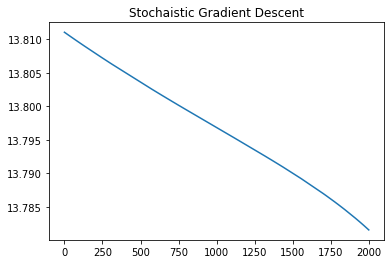

In [109]:
#split data to train and test
train_rating, test_rating = train_test_split( ratings_by_user, test_size=0.33, random_state=42)
#create sparse matrices for train and test
dense_shape = (users_df.shape[0], movies_df.shape[0])
sp_tensor_train = create_sparse_tensor(train_rating[['user_id', 'movie_id']].values,np.array(train_rating['rating']),dense_shape)
sp_tensor_test = create_sparse_tensor(test_rating[['user_id', 'movie_id']].values,np.array(test_rating['rating']),dense_shape)
users_vector = tf.Variable(tf.random.normal([sp_tensor_train.dense_shape[0], 5], stddev=0.1))
movies_vector = tf.Variable(tf.random.normal([sp_tensor_train.dense_shape[1], 5], stddev=0.1))
#loss calculation
train_loss = calculate_mean_square_err(sp_tensor_train, users_vector, movies_vector)
test_loss = calculate_mean_square_err(sp_tensor_test, users_vector, movies_vector)
# Penalise the loss value to avoid overfitting. 
feedback_loss_val = build_cost_function(train_loss,users_vector,movies_vector)

#Hyper parameters 
learning_rate = 0.1
embeddings = train_model(users_vector,movies_vector,feedback_loss_val,iteration_count=2000)


          

In [110]:
recommendations_df = get_movie_recommendation(embeddings,movies_df, 900)
recommendations_df.head(5)

,movie_id,title,score
602,603,Rear Window (1954),0.039521
131,132,"Wizard of Oz, The (1939)",0.037025
690,691,Dark City (1998),0.036990
1050,1051,"Associate, The (1996)",0.036752
619,620,"Chamber, The (1996)",0.036613
